In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable
from tqdm import tqdm

In [2]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from PIL import ImageFilter
import os
import sys
import numpy as np

In [3]:
# @title
class PairedImageDataset(Dataset):
    def __init__(self, root_dir_original, root_dir_corrupted, transform=None):
        self.root_dir_original = root_dir_original
        self.root_dir_corrupted = root_dir_corrupted
        self.transform = transform

        self.original_image_list = os.listdir(root_dir_original)
        self.corrupted_image_list = os.listdir(root_dir_corrupted)

    def __len__(self):
        # Ensure the datasets have the same length
        return min(len(self.original_image_list), len(self.corrupted_image_list))

    def __getitem__(self, idx):
        original_img_name = self.original_image_list[idx]
        corrupted_img_name = self.corrupted_image_list[idx]

        original_img_path = os.path.join(self.root_dir_original, original_img_name)
        corrupted_img_path = os.path.join(self.root_dir_corrupted, corrupted_img_name)

        # Load the original and corrupted images
        original_img = Image.open(original_img_path).convert('RGB')
        corrupted_img = Image.open(corrupted_img_path).convert('RGB')

        # Apply transformations
        if self.transform:
            original_img = self.transform(original_img)
            corrupted_img = self.transform(corrupted_img)

        return original_img, corrupted_img

# Specify the path to your datasets
original_dataset_root = './datasets/train/all'
corrupted_dataset_root = './datasets/train/all_paired'
transform = transforms.Compose([transforms.Resize((256,256)),transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Create the dataset
paired_image_dataset = PairedImageDataset(root_dir_original=original_dataset_root,
                                          root_dir_corrupted=corrupted_dataset_root,
                                          transform=transform)

# Create the dataloader
batch_size = 8
dataloader = DataLoader(paired_image_dataset, batch_size=batch_size, shuffle=True, num_workers=8)

# Iterate over the dataset
# for batch in dataloader:
#     # Access batch['original'] and batch['corrupted'] for processing
#     original_images, corrupted_images = batch
#     # Your processing code here

In [4]:
class Generator(nn.Module):
    def __init__(self,num_channels=3,latent_dim=100):
        super(Generator,self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Flatten(),
            # nn.Linear(512 * 16 * 16, latent_dim)
        )
        self.fc = nn.Linear(512 * 16 * 16, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512 * 16 * 16),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (512, 16, 16)),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, num_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
    def forward(self,x):
        # print(x.shape)
        # print('entering enc')
        x = self.encoder(x)
        # print('entering fc')
        x = self.fc(x)
        # print(x.shape)
        # print('entering dc')
        x = self.decoder(x)
        # print(x.shape)
        return x

In [5]:
class Discriminator(nn.Module):
    def __init__(self, num_channels=3):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(num_channels * 2, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(512 * 16 * 16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # print(x.shape)
        # print('entering disc')
        x = self.model(x)
        # print(x.shape)
        return x

In [6]:
patch_size = 16
class LocalDiscriminator(nn.Module):
    def __init__(self, input_channels=3, num_patches=4):
        super(LocalDiscriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(input_channels * 2, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Flatten(),
            nn.Linear(256*16*16,1),
            nn.Sigmoid()
        )
        # Example: Convolutional layers for patch discrimination
        # Add more layers as needed

        # Output layer for binary classification
        self.fc = nn.Linear(128 * patch_size * patch_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        return x

In [7]:
patch_size = 64
class LocalDiscriminator64(nn.Module):
    def __init__(self, input_channels=3, num_patches=4):
        super(LocalDiscriminator64, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(input_channels * 2, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True),
            nn.Flatten(),
            nn.Linear(256*8*8,1),
            nn.Sigmoid()
        )
        # Example: Convolutional layers for patch discrimination
        # Add more layers as needed

        # Output layer for binary classification
        self.fc = nn.Linear(128 * patch_size * patch_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.model(x)
        return x

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
num_channels=3
def gan_loss(generator, discriminator, local_discriminator, original_images, corrupted_images, lambda_recon=100, lambda_global=100, lambda_local=100):
    # Forward pass through the generator
    generator=generator.to(device)
    discriminator=discriminator.to(device)
    local_discriminator=local_discriminator.to(device)
    original_images=original_images.to(device)
    corrupted_images=corrupted_images.to(device)
    inpainted_images = generator(corrupted_images)
    # Concatenate original and inpainted images along the channel dimension
    combined_images = torch.cat((original_images, inpainted_images), dim=1)
    combined_images=combined_images.to(device)

    # Forward pass through the discriminator
    discriminator_output = discriminator(combined_images)

    # Target labels for the discriminator
    real_labels = torch.ones_like(discriminator_output)
    fake_labels = torch.zeros_like(discriminator_output)

    # Reconstruction loss (L1 loss)
    recon_loss = nn.functional.l1_loss(inpainted_images, original_images) * lambda_recon

    # Global discriminator loss (binary cross-entropy)
    global_discriminator_loss = F.binary_cross_entropy(discriminator_output, real_labels) * lambda_global

    # Local discriminator loss (binary cross-entropy on local patches)
    local_discriminator_loss = 0.0
    # patch_size = 16  # Adjust the patch size based on your preference

    # for i in range(0, original_images.size(2) - patch_size + 1, patch_size):
    #     for j in range(0, original_images.size(3) - patch_size + 1, patch_size):
    #         # Extract local patches from original and inpainted images
    #         original_patch = original_images[:, :, i:i+patch_size, j:j+patch_size]
    #         inpainted_patch = inpainted_images[:, :, i:i+patch_size, j:j+patch_size]

    #         # Concatenate patches along the channel dimension
    #         combined_patch = torch.cat((original_patch, inpainted_patch), dim=1)

    #         # Forward pass through the local discriminator
    #         discriminator_output_patch = local_discriminator(combined_patch)
    #         # local_real_labels = torch.ones_like(local_discriminator(discriminator_output_patch))
    #         # local_fake_labels = torch.zeros_like(local_discriminator(discriminator_output_patch))
    #         # Compute local discriminator loss
    #         local_discriminator_loss += F.binary_cross_entropy(discriminator_output_patch, real_labels) * lambda_local

    # Total GAN loss
    total_loss = recon_loss + global_discriminator_loss + local_discriminator_loss

    return total_loss, recon_loss, global_discriminator_loss, local_discriminator_loss

In [10]:
# lambda_recon = 10
# lambda_global = 100
# lambda_local = 1

# generator = Generator()
# discriminator = Discriminator()
# local_discriminator = LocalDiscriminator()

# # Define the optimizer for generator and discriminator
# optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
# optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))
# optimizer_local_discriminator = torch.optim.Adam(local_discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))

# # Forward and backward passes, and optimization steps
# optimizer_generator.zero_grad()
# optimizer_discriminator.zero_grad()
# optimizer_local_discriminator.zero_grad()

# # total_loss = gan_loss(generator, discriminator, original_images, corrupted_images, lambda_recon, lambda_global, lambda_local)

# # total_loss.backward()
# # optimizer_generator.step()
# # optimizer_discriminator.step()

In [11]:
# num_epochs = 200
# generator.to(device)
# discriminator.to(device)
# local_discriminator.to(device)
# for epoch in range(num_epochs):
#     for i, (original_images, corrupted_images) in enumerate(dataloader):
#         # Set model gradients to zero

#         # Forward pass and calculate GAN loss
#         total_loss = gan_loss(generator, discriminator, local_discriminator, original_images, corrupted_images, lambda_recon, lambda_global, lambda_local)

#         # Backward pass and optimization steps
#         # if i%4==0:
#         total_loss.backward()
#         optimizer_generator.step()
#         optimizer_discriminator.step()
#         optimizer_local_discriminator.step()
#         optimizer_generator.zero_grad()
#         optimizer_discriminator.zero_grad()
#         optimizer_local_discriminator.zero_grad()

#         # Print training statistics
#         if i % 10 == 0:
#             print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {total_loss.item():.4f}')
#     if epoch%5==4:
#         torch.save(generator.state_dict(), '/content/drive/MyDrive/generator.pt')
#         torch.save(discriminator.state_dict(), '/content/drive/MyDrive/discriminator.pt')
#         torch.save(local_discriminator.state_dict(), '/content/drive/MyDrive/local_discriminator.pt')
#         print(f'saved on epoch: {epoch+1}')

In [12]:
# torch.save(generator.state_dict(), '/content/drive/MyDrive/generator200.pt')
# torch.save(discriminator.state_dict(), '/content/drive/MyDrive/discriminator200.pt')

In [13]:
gen = Generator()
k = torch.load('./generator.pt',map_location='cpu')
gen.load_state_dict(k)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# paired_image_dataset = PairedImageDataset(root_dir_original=original_dataset_root,
#                                           root_dir_corrupted=corrupted_dataset_root,
#                                           transform=transform)
# dataloader = DataLoader(paired_image_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

tensor(-1.0000) tensor(1.)


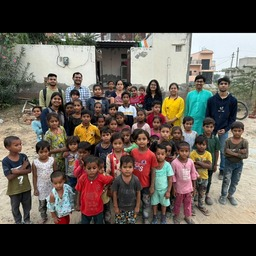

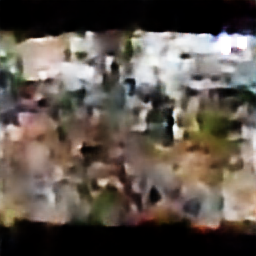

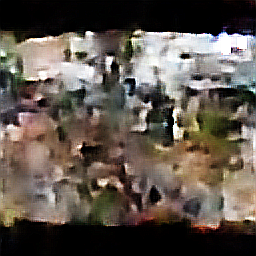

In [16]:
# input_image_path = './datasets/train/all_paired/E4_28.jpeg'
input_image_path = './chacha.jpeg'
input_image = Image.open(input_image_path).convert('RGB')
# Preprocess the input image
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

input_image_tensor = transform(input_image).unsqueeze(0)  # Add batch dimension

# Set the generator in evaluation mode
gen.eval()
gen = gen.cpu()
# Generate inpainted image
with torch.no_grad():
    inpainted_image_tensor = gen(input_image_tensor)

# Convert the generated tensor back to an image
inpainted_image = transforms.ToPILImage()((inpainted_image_tensor.squeeze(0)+1)/2.0)
fi = inpainted_image.filter(ImageFilter.EDGE_ENHANCE)
# fi = inpainted_image.filter(ImageFilter.SHARPEN)

# inpainted_image = transforms.ToPILImage()(inpainted_image_tensor.squeeze(0))

# Save or display the inpainted image
# np.set_printoptions(threshold=sys.maxsize)
print(inpainted_image_tensor.min(), inpainted_image_tensor.max())
# print(inpainted_image_tensor.numpy()[0][0])
inpainted_image.save('./inpainted_image18.jpg')
display(input_image,inpainted_image,fi)

In [65]:
# print(generator)

In [24]:
progress=530
num_epochs=50
generator = Generator()
g = torch.load('./generator.pt',map_location='cpu')
generator.load_state_dict(g)
discriminator = Discriminator()
d = torch.load('./discriminator.pt',map_location='cpu')
discriminator.load_state_dict(d)
local_discriminator = LocalDiscriminator64()
l = torch.load('./local_discriminator.pt',map_location='cpu')
local_discriminator.load_state_dict(l)

generator = generator.to(device)
discriminator = discriminator.to(device)
# local_discriminator = local_discriminator.to(device)

lambda_recon = 5
lambda_global = 100
lambda_local = 10000


optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
# optimizer_local_discriminator = torch.optim.Adam(local_discriminator.parameters(), lr=0.002, betas=(0.5, 0.999))

optimizer_generator.zero_grad()
optimizer_discriminator.zero_grad()
# optimizer_local_discriminator.zero_grad()

for epoch in range(num_epochs):
    for i, (original_images, corrupted_images) in tqdm(enumerate(dataloader)):
        # Set model gradients to zero

        # Forward pass and calculate GAN loss
        total_loss, recon_loss, global_discriminator_loss, local_discriminator_loss = gan_loss(generator, discriminator, local_discriminator, original_images, corrupted_images, lambda_recon, lambda_global, lambda_local)

        # Backward pass and optimization steps
        # if i%4==0:
        total_loss.backward()
        # local_discriminator_loss.backward()
        optimizer_generator.step()
        optimizer_discriminator.step()
        # optimizer_local_discriminator.step()
        optimizer_generator.zero_grad()
        optimizer_discriminator.zero_grad()
        # optimizer_local_discriminator.zero_grad()

        # Print training statistics
        if i % 100 == 0:
            print(f'Epoch [{epoch+1+progress}/{num_epochs+progress}], Step [{i+1}/{len(dataloader)}], recon Loss: {recon_loss.item():.6f}, GD Loss: {global_discriminator_loss.item():.6f}, Total Loss: {total_loss.item():.6f}')
    if epoch%5==4:
        torch.save(generator.state_dict(), '/content/drive/MyDrive/generator.pt')
        torch.save(discriminator.state_dict(), '/content/drive/MyDrive/discriminator.pt')
        # torch.save(local_discriminator.state_dict(), '/content/drive/MyDrive/local_discriminator.pt')
        print(f'Model saved successfully on epoch: {epoch+1+progress}')

In [67]:
torch.save(generator.state_dict(), f'/content/drive/MyDrive/generator{num_epochs+progress}.pt')
torch.save(discriminator.state_dict(), f'/content/drive/MyDrive/discriminator{num_epochs+progress}.pt')
# torch.save(local_discriminator.state_dict(), f'/content/drive/MyDrive/local_discriminator64_{num_epochs+progress}.pt')